#Downloading Chest X-ray Pneumonia Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Colab_Notebooks/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:25<00:00, 85.2MB/s]
100% 2.29G/2.29G [00:25<00:00, 98.2MB/s]


In [ ]:
!unzip /content/chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

#Importing the Necessary Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import cv2
from skimage.io import imread
from skimage.transform import rescale
from skimage.feature import hog
from skimage import exposure
from skimage import color
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing import image
from PIL import Image
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Input, UpSampling2D, Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.src.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#Dataset Creation

In [ ]:
def remove_ds_store_files(folder_paths):
    for folder_path in folder_paths:
        ds_store_path_normal = os.path.join(folder_path, 'NORMAL/.DS_Store')
        ds_store_path_pneumonia = os.path.join(folder_path, 'PNEUMONIA/.DS_Store')

        if os.path.exists(ds_store_path_normal):
            os.remove(ds_store_path_normal)
            print(f"The file {ds_store_path_normal} has been removed.")
        else:
            print(f"The file {ds_store_path_normal} does not exist.")

        if os.path.exists(ds_store_path_pneumonia):
            os.remove(ds_store_path_pneumonia)
            print(f"The file {ds_store_path_pneumonia} has been removed.")
        else:
            print(f"The file {ds_store_path_pneumonia} does not exist.")

folder_paths = [
    "/content/chest_xray/chest_xray/train",
    "/content/chest_xray/chest_xray/test",
    "/content/chest_xray/chest_xray/val"
]

remove_ds_store_files(folder_paths)

The file /content/chest_xray/chest_xray/train/NORMAL/.DS_Store has been removed.
The file /content/chest_xray/chest_xray/train/PNEUMONIA/.DS_Store has been removed.
The file /content/chest_xray/chest_xray/test/NORMAL/.DS_Store does not exist.
The file /content/chest_xray/chest_xray/test/PNEUMONIA/.DS_Store does not exist.
The file /content/chest_xray/chest_xray/val/NORMAL/.DS_Store has been removed.
The file /content/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store has been removed.


In [ ]:
data_dir = "/content/chest_xray/chest_xray/train"

normal_df = pd.DataFrame(columns=['filepaths', 'labels'])
pneumonia_df = pd.DataFrame(columns=['filepaths', 'labels'])

normal_label = 0
pneumonia_label = 1

normal_files = os.listdir(os.path.join(data_dir, "NORMAL"))
pneumonia_files = os.listdir(os.path.join(data_dir, "PNEUMONIA"))

normal_df['filepaths'] = [os.path.join(data_dir, "NORMAL", filename) for filename in normal_files]
normal_df['labels'] = normal_label

pneumonia_df['filepaths'] = [os.path.join(data_dir, "PNEUMONIA", filename) for filename in pneumonia_files]
pneumonia_df['labels'] = pneumonia_label


In [ ]:
'''

train_dir = "/content/chest_xray/chest_xray/train"
test_dir = "/content/chest_xray/chest_xray/test"
val_dir = "/content/chest_xray/chest_xray/val"

normal_label = 0
pneumonia_label = 1

def create_dataframe(directory, label):
    df = pd.DataFrame(columns=['filepaths', 'labels'])

    files = os.listdir(os.path.join(directory, label))
    filepaths = [os.path.join(directory, label, filename) for filename in files]
    labels = [label] * len(files)

    df['filepaths'] = filepaths
    df['labels'] = labels

    return df

normal_df_train = create_dataframe(train_dir, "NORMAL")
normal_df_test = create_dataframe(test_dir, "NORMAL")
normal_df_val = create_dataframe(val_dir, "NORMAL")

pneumonia_df_train = create_dataframe(train_dir, "PNEUMONIA")
pneumonia_df_test = create_dataframe(test_dir, "PNEUMONIA")
pneumonia_df_val = create_dataframe(val_dir, "PNEUMONIA")

normal_df = pd.concat([normal_df_train, normal_df_test, normal_df_val], ignore_index=True)
pneumonia_df = pd.concat([pneumonia_df_train, pneumonia_df_test, pneumonia_df_val], ignore_index=True)

'''

In [ ]:
pneumonia_df.head(5)

,filepaths,labels
0,/content/chest_xray/chest_xray/train/PNEUMONIA...,1
1,/content/chest_xray/chest_xray/train/PNEUMONIA...,1
2,/content/chest_xray/chest_xray/train/PNEUMONIA...,1
3,/content/chest_xray/chest_xray/train/PNEUMONIA...,1
4,/content/chest_xray/chest_xray/train/PNEUMONIA...,1


In [ ]:
combined_df = pd.concat([normal_df, pneumonia_df], ignore_index=True)

label_counts = combined_df['labels'].value_counts()
print("\nLabel Counts:")
print(label_counts)


Label Counts:
1    3875
0    1341
Name: labels, dtype: int64


#Image Augmentation and Processing

In [ ]:
def augment(img):
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
    )

    img = np.expand_dims(img, 0)
    augmented_images = datagen.flow(img)

    return augmented_images[0]

def process_images(filepaths, image_size=(128, 128)):
    images = []
    for path in filepaths:
        try:
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, image_size)
            img = img.astype(np.float32) / 255.0

            augmented_img = augment(img)
            augmented_img = np.squeeze(augmented_img, axis=0)

            images.append(augmented_img)
        except Exception as e:
            print(f"Error processing image at path: {path}")
            print(f"Details: {str(e)}")

    return tf.convert_to_tensor(images)

normal_tensor = process_images(normal_df['filepaths'].values)
pneumonia_tensor = process_images(pneumonia_df['filepaths'].values)

print("Normal Tensor Shape:", normal_tensor.shape)
print("Pneumonia Tensor Shape:", pneumonia_tensor.shape)

Normal Tensor Shape: (1341, 128, 128, 3)
Pneumonia Tensor Shape: (3875, 128, 128, 3)


#Data Splitting and Dataset Preparation

In [ ]:
normal_labels = np.zeros(len(normal_tensor), dtype=np.int64)
pneumonia_labels = np.ones(len(pneumonia_tensor), dtype=np.int64)
labels = np.concatenate((normal_labels, pneumonia_labels), axis=0)

images = np.concatenate((normal_tensor, pneumonia_tensor), axis=0)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels)

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [ ]:
train_dataset_cardinality = train_dataset.cardinality()
print("Number of elements in train_dataset:", train_dataset_cardinality)

test_dataset_cardinality = test_dataset.cardinality()
print("Number of elements in test_dataset:", test_dataset_cardinality)

Number of elements in train_dataset: tf.Tensor(4172, shape=(), dtype=int64)
Number of elements in test_dataset: tf.Tensor(1044, shape=(), dtype=int64)


In [ ]:
batch_size = 32

train_data = train_dataset.shuffle(10000).batch(batch_size)
test_data = test_dataset.batch(batch_size)

In [ ]:
for image,label in train_data.take(1):
    print(image.shape)

(32, 128, 128, 3)


#Data Visualization

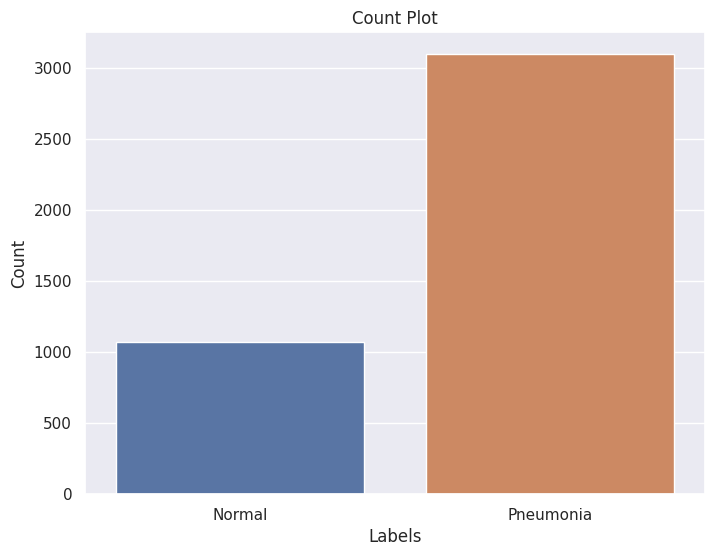

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x=train_labels)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Normal', 'Pneumonia'])
plt.title('Count Plot')
plt.show()

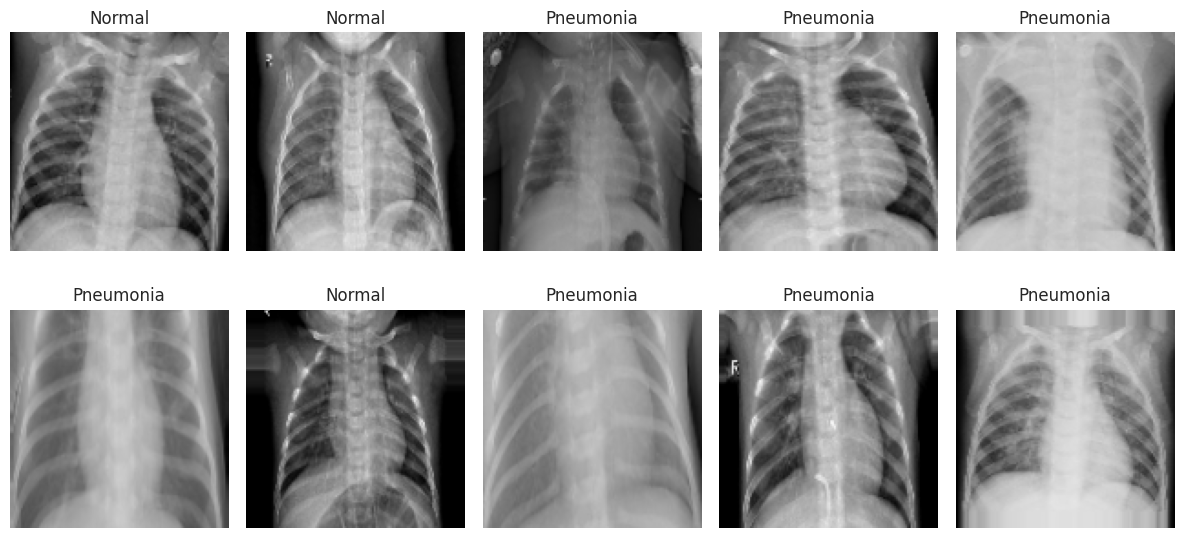

In [ ]:
label_names = ['Normal', 'Pneumonia']

def plot_images(images, labels, rows=2, cols=5):
    plt.figure(figsize=(12, 6))
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        plt.title(label_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(train_images[:10], train_labels[:10])

#Machine Learning Model

##HOG Feature Extraction

In [ ]:
def compute_hog_features(images):
    hog_features = []
    for image in images:
        gray_image = color.rgb2gray(image)
        fd, hog_image = hog(gray_image, orientations=8, pixels_per_cell=(4, 4),
                            cells_per_block=(1, 1), visualize=True)

        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        hog_features.append(fd)
    return np.array(hog_features)

train_hog_features = compute_hog_features(train_images)
test_hog_features = compute_hog_features(test_images)

##Random Forest Classification and Evaluation

In [ ]:
random_forest = RandomForestClassifier(n_estimators=1000, random_state=42)
random_forest.fit(train_hog_features, train_labels)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [ ]:
predictions = random_forest.predict(test_hog_features)

accuracy = accuracy_score(test_labels, predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

report = classification_report(test_labels, predictions)
print("Classification Report:\n", report)

Accuracy: 85.82%
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.51      0.65       268
           1       0.85      0.98      0.91       776

    accuracy                           0.86      1044
   macro avg       0.87      0.74      0.78      1044
weighted avg       0.86      0.86      0.84      1044



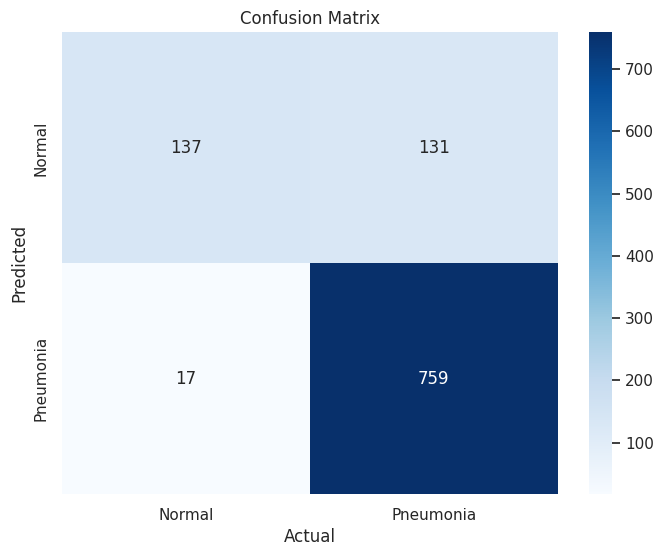

In [ ]:
conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Deep Learning Models

##Transfer Learning(TL)

###Mobilenet based Model

In [ ]:
base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (128,128,3))
base_model.trainable = False

x = base_model.output
x= Flatten()(x)
x = Dense(256, activation= 'relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation= 'sigmoid')(x)
model = Model(inputs = base_model.input, outputs = predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

###Model Training

In [ ]:
history = model.fit(train_data, epochs=10, validation_data= test_data)

Epoch 1/10
131/131 [==============================] - 16s 36ms/step - loss: 0.4368 - accuracy: 0.9113 - val_loss: 0.1492 - val_accuracy: 0.9425
Epoch 2/10
131/131 [==============================] - 3s 23ms/step - loss: 0.1120 - accuracy: 0.9552 - val_loss: 0.1371 - val_accuracy: 0.9483
Epoch 3/10
131/131 [==============================] - 3s 24ms/step - loss: 0.0819 - accuracy: 0.9688 - val_loss: 0.1317 - val_accuracy: 0.9531
Epoch 4/10
131/131 [==============================] - 3s 23ms/step - loss: 0.0790 - accuracy: 0.9686 - val_loss: 0.1456 - val_accuracy: 0.9464
Epoch 5/10
131/131 [==============================] - 3s 23ms/step - loss: 0.0429 - accuracy: 0.9835 - val_loss: 0.1217 - val_accuracy: 0.9531
Epoch 6/10
131/131 [==============================] - 3s 24ms/step - loss: 0.0363 - accuracy: 0.9866 - val_loss: 0.1460 - val_accuracy: 0.9540
Epoch 7/10
131/131 [==============================] - 3s 23ms/step - loss: 0.0393 - accuracy: 0.9844 - val_loss: 0.1343 - val_accuracy: 0.952

###Training and Validation Metrics Visualization

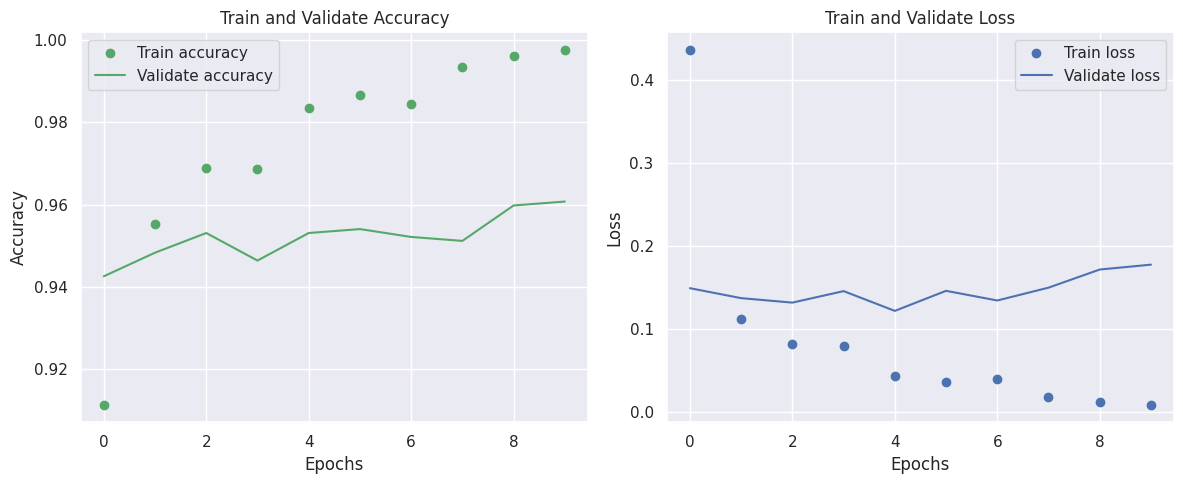

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, 'go', label='Train accuracy')
plt.plot(val_acc, 'g', label='Validate accuracy')
plt.title('Train and Validate Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, 'bo', label='Train loss')
plt.plot(val_loss, 'b', label='Validate loss')
plt.title('Train and Validate Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

###Model Evaluation

In [ ]:
probabilities = model.predict(test_data)
predicted_classes = (probabilities > 0.5).astype(int)

33/33 [==============================] - 1s 17ms/step


In [ ]:
report = classification_report(test_labels, predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       268
           1       0.97      0.98      0.97       776

    accuracy                           0.96      1044
   macro avg       0.95      0.95      0.95      1044
weighted avg       0.96      0.96      0.96      1044



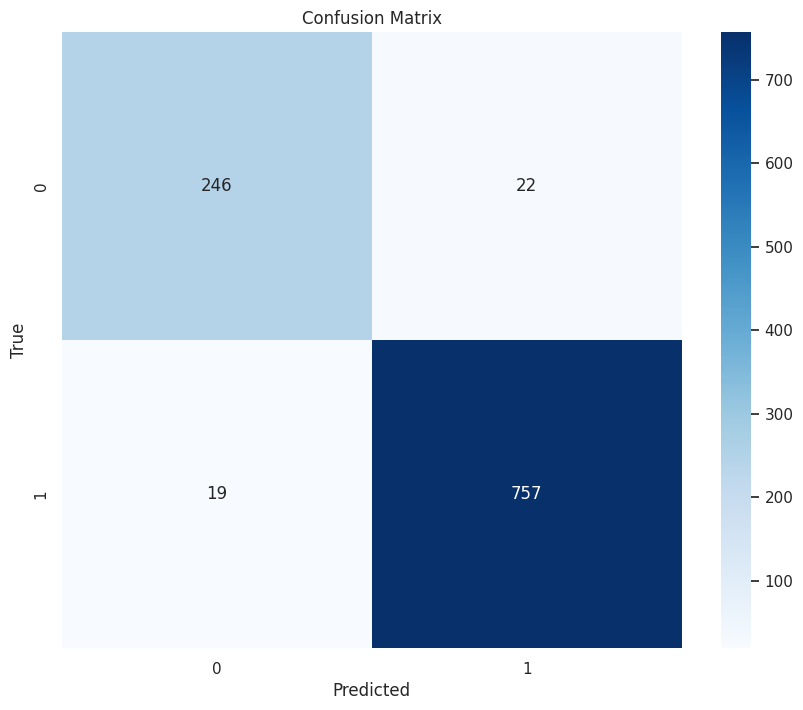

In [ ]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
results = model.evaluate(test_data, verbose=True)

loss = round(results[0], 2)
accuracy = round(results[1] * 100, 2)

print(f'Test results - Loss: {loss} - Accuracy: {accuracy}%')

33/33 [==============================] - 1s 23ms/step - loss: 0.1776 - accuracy: 0.9607
Test results - Loss: 0.18 - Accuracy: 96.07%


###Prediction using Mobilnet based Model

In [ ]:
def predict_pneumonia_or_normal(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    predictions = model.predict(img_preprocessed)

    if predictions[0] > 0.5:
        return '\nPrediction: Pneumonia (Class 1)\n'
    else:
        return '\nPrediction: Normal (Class 0)\n'

img_paths = [
    '/content/chest_xray/chest_xray/test/PNEUMONIA/person101_bacteria_484.jpeg',
    '/content/chest_xray/chest_xray/test/PNEUMONIA/person102_bacteria_487.jpeg',
    '/content/chest_xray/chest_xray/test/NORMAL/IM-0005-0001.jpeg',
    '/content/chest_xray/chest_xray/test/NORMAL/IM-0015-0001.jpeg'
]

for img_path in img_paths:
    prediction = predict_pneumonia_or_normal(img_path)
    print(f'For image {img_path}, {prediction}')

1/1 [==============================] - 1s 1s/step
For image /content/chest_xray/chest_xray/test/PNEUMONIA/person101_bacteria_484.jpeg, 
Prediction: Pneumonia (Class 1)

1/1 [==============================] - 0s 26ms/step
For image /content/chest_xray/chest_xray/test/PNEUMONIA/person102_bacteria_487.jpeg, 
Prediction: Pneumonia (Class 1)

1/1 [==============================] - 0s 21ms/step
For image /content/chest_xray/chest_xray/test/NORMAL/IM-0005-0001.jpeg, 
Prediction: Normal (Class 0)

1/1 [==============================] - 0s 23ms/step
For image /content/chest_xray/chest_xray/test/NORMAL/IM-0015-0001.jpeg, 
Prediction: Normal (Class 0)



##Convolutional Neural Network (CNN)

###CNN Model

In [ ]:
model_cnn = Sequential()

model_cnn.add(Conv2D(filters = 32, kernel_size = (1,1), input_shape = [128,128,3]))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPool2D(pool_size = (2,2)))

model_cnn.add(Conv2D(filters = 64, kernel_size = (3,3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPool2D(pool_size = (2,2)))

model_cnn.add(Conv2D(filters = 128, kernel_size = (3,3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPool2D(pool_size = (2,2)))

model_cnn.add(Flatten())

model_cnn.add(Dense(units = 32))
model_cnn.add(Activation('relu'))

model_cnn.add(Dense(units = 64))
model_cnn.add(Activation('relu'))

model_cnn.add(Dense(units = 128))
model_cnn.add(Activation('relu'))

model_cnn.add(Dense(units = 256))
model_cnn.add(Activation('relu'))

model_cnn.add(Dense(units = 1, activation = 'sigmoid'))

model_cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      128       
                                                                 
 activation_14 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 activation_15 (Activation)  (None, 62, 62, 64)        0         
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 31, 31, 64)        0         
 g2D)                                                 

###Model Training

In [ ]:
history_cnn = model_cnn.fit(train_data, epochs=10, validation_data= test_data)

Epoch 1/10
131/131 [==============================] - 6s 23ms/step - loss: 0.4214 - accuracy: 0.8207 - val_loss: 0.2835 - val_accuracy: 0.8793
Epoch 2/10
131/131 [==============================] - 3s 23ms/step - loss: 0.2304 - accuracy: 0.9060 - val_loss: 0.2691 - val_accuracy: 0.8851
Epoch 3/10
131/131 [==============================] - 3s 22ms/step - loss: 0.2054 - accuracy: 0.9178 - val_loss: 0.3423 - val_accuracy: 0.8573
Epoch 4/10
131/131 [==============================] - 3s 22ms/step - loss: 0.1676 - accuracy: 0.9314 - val_loss: 0.2066 - val_accuracy: 0.9243
Epoch 5/10
131/131 [==============================] - 3s 23ms/step - loss: 0.1477 - accuracy: 0.9470 - val_loss: 0.1710 - val_accuracy: 0.9425
Epoch 6/10
131/131 [==============================] - 3s 22ms/step - loss: 0.1153 - accuracy: 0.9573 - val_loss: 0.1969 - val_accuracy: 0.9358
Epoch 7/10
131/131 [==============================] - 3s 22ms/step - loss: 0.1088 - accuracy: 0.9621 - val_loss: 0.1693 - val_accuracy: 0.9416

###Training and Validation Metrics Visualization

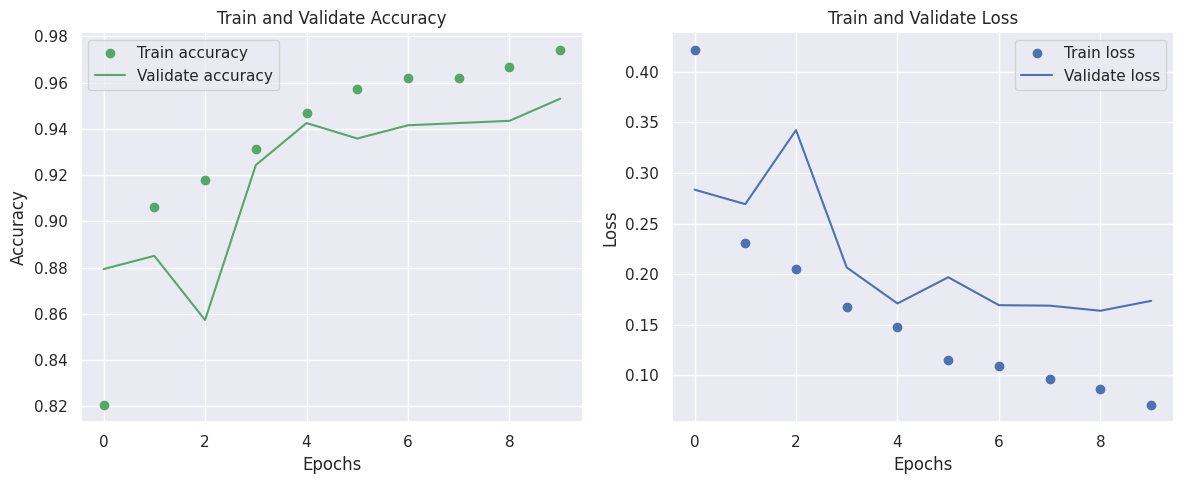

In [ ]:
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, 'go', label='Train accuracy')
plt.plot(val_acc, 'g', label='Validate accuracy')
plt.title('Train and Validate Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, 'bo', label='Train loss')
plt.plot(val_loss, 'b', label='Validate loss')
plt.title('Train and Validate Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

###Model Evaluation

In [ ]:
probabilities = model_cnn.predict(test_data)
predicted_classes = (probabilities > 0.5).astype(int)

report = classification_report(test_labels, predicted_classes)
print(report)

33/33 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       268
           1       0.97      0.97      0.97       776

    accuracy                           0.95      1044
   macro avg       0.94      0.94      0.94      1044
weighted avg       0.95      0.95      0.95      1044



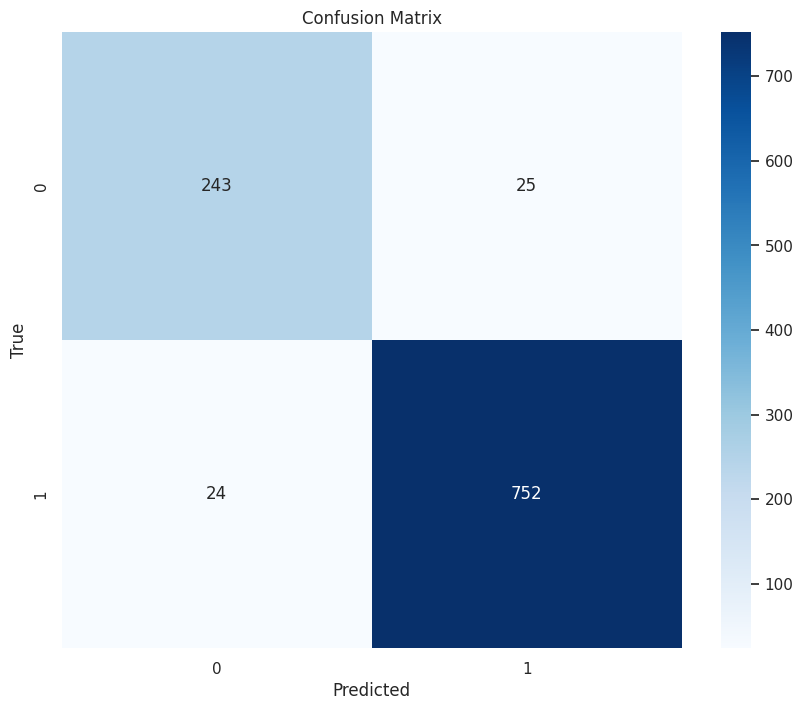

In [ ]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
results = model_cnn.evaluate(test_data, verbose=True)

loss = round(results[0], 2)
accuracy = round(results[1] * 100, 2)

print(f'Test results - Loss: {loss} - Accuracy: {accuracy}%')

33/33 [==============================] - 0s 10ms/step - loss: 0.1736 - accuracy: 0.9531
Test results - Loss: 0.17 - Accuracy: 95.31%


###Prediction using CNN Model

In [ ]:
def predict_pneumonia_or_normal(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model_cnn.predict(img)

    if prediction[0] > 0.5:
        return '\nPrediction: Pneumonia (Class 1)\n'
    else:
        return '\nPrediction: Normal (Class 0)\n'

img_paths = [
    '/content/chest_xray/chest_xray/test/PNEUMONIA/person101_bacteria_484.jpeg',
    '/content/chest_xray/chest_xray/test/PNEUMONIA/person102_bacteria_487.jpeg',
    '/content/chest_xray/chest_xray/test/NORMAL/IM-0007-0001.jpeg',
    '/content/chest_xray/chest_xray/test/NORMAL/IM-0009-0001.jpeg'
]

for img_path in img_paths:
    prediction = predict_pneumonia_or_normal(img_path)
    print(f'For image {img_path}, {prediction}')

1/1 [==============================] - 0s 31ms/step
For image /content/chest_xray/chest_xray/test/PNEUMONIA/person101_bacteria_484.jpeg, 
Prediction: Pneumonia (Class 1)

1/1 [==============================] - 0s 30ms/step
For image /content/chest_xray/chest_xray/test/PNEUMONIA/person102_bacteria_487.jpeg, 
Prediction: Pneumonia (Class 1)

1/1 [==============================] - 0s 32ms/step
For image /content/chest_xray/chest_xray/test/NORMAL/IM-0007-0001.jpeg, 
Prediction: Normal (Class 0)

1/1 [==============================] - 0s 33ms/step
For image /content/chest_xray/chest_xray/test/NORMAL/IM-0009-0001.jpeg, 
Prediction: Normal (Class 0)



##Autoencoder

###Autoencoder-based Encoder and Classifier

In [ ]:
input_img = Input(shape=(128, 128, 3))

x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPool2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x= MaxPool2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPool2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        4640  

In [ ]:
autoencoder.fit(train_images, train_images, epochs=5, batch_size=16)

Epoch 1/5
261/261 [==============================] - 16s 13ms/step - loss: 0.0185
Epoch 2/5
261/261 [==============================] - 5s 17ms/step - loss: 0.0028
Epoch 3/5
261/261 [==============================] - 3s 11ms/step - loss: 0.0023
Epoch 4/5
261/261 [==============================] - 2s 10ms/step - loss: 0.0021
Epoch 5/5
261/261 [==============================] - 3s 10ms/step - loss: 0.0019


In [ ]:
encoder = Model(input_img, encoded)

classifier_input = Input(shape=(16, 16, 32))
x = Flatten()(classifier_input)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
model_encoder = Model(classifier_input, x)

model_encoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model_encoder.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 16, 16, 32)]      0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1048704   
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1048833 (4.00 MB)
Trainable params: 1048833 (4.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


###Model Training

In [ ]:
encoded_train = encoder.predict(train_images)
encoded_test= encoder.predict(test_images)

history_encoder= model_encoder.fit(encoded_train, train_labels, epochs=5, batch_size=32, validation_data=(encoded_test, test_labels))

33/33 [==============================] - 0s 8ms/step
Epoch 1/5
131/131 [==============================] - 3s 6ms/step - loss: 0.2991 - accuracy: 0.8722 - val_loss: 0.2352 - val_accuracy: 0.9013
Epoch 2/5
131/131 [==============================] - 1s 5ms/step - loss: 0.1765 - accuracy: 0.9338 - val_loss: 0.1804 - val_accuracy: 0.9262
Epoch 3/5
131/131 [==============================] - 1s 4ms/step - loss: 0.1583 - accuracy: 0.9379 - val_loss: 0.1937 - val_accuracy: 0.9215
Epoch 4/5
131/131 [==============================] - 1s 4ms/step - loss: 0.1494 - accuracy: 0.9413 - val_loss: 0.1847 - val_accuracy: 0.9215
Epoch 5/5
131/131 [==============================] - 1s 5ms/step - loss: 0.1399 - accuracy: 0.9444 - val_loss: 0.1818 - val_accuracy: 0.9282


###Training and Validation Metrics Visualization

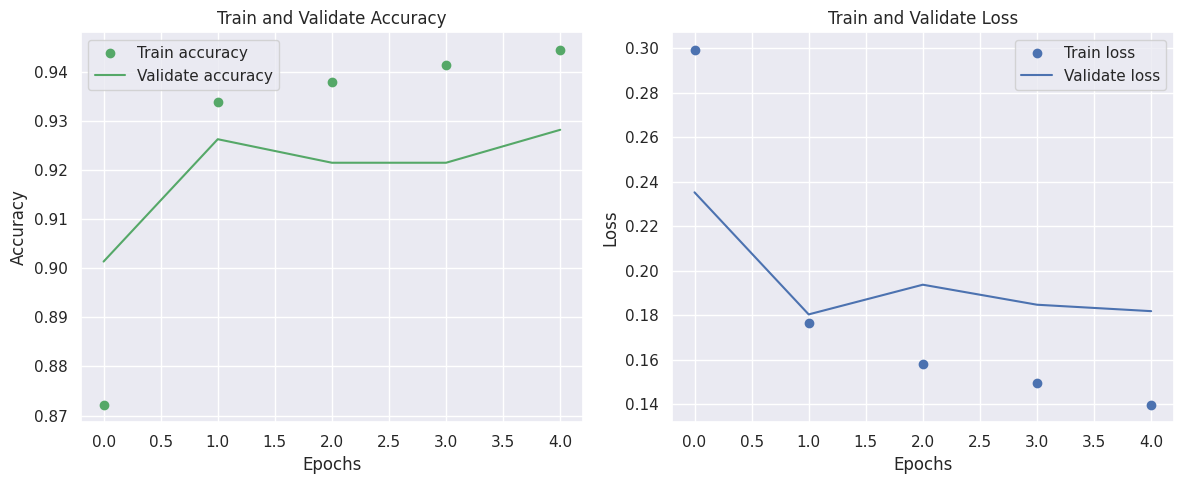

In [ ]:
acc = history_encoder.history['accuracy']
val_acc = history_encoder.history['val_accuracy']
loss = history_encoder.history['loss']
val_loss = history_encoder.history['val_loss']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, 'go', label='Train accuracy')
plt.plot(val_acc, 'g', label='Validate accuracy')
plt.title('Train and Validate Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, 'bo', label='Train loss')
plt.plot(val_loss, 'b', label='Validate loss')
plt.title('Train and Validate Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

###Model Evaluation

In [ ]:
probabilities = model_encoder.predict(encoded_test)
predicted_classes = (probabilities > 0.5).astype(int)

report = classification_report(test_labels, predicted_classes)
print(report)

33/33 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.94      0.77      0.85       268
           1       0.93      0.98      0.95       776

    accuracy                           0.93      1044
   macro avg       0.93      0.88      0.90      1044
weighted avg       0.93      0.93      0.93      1044



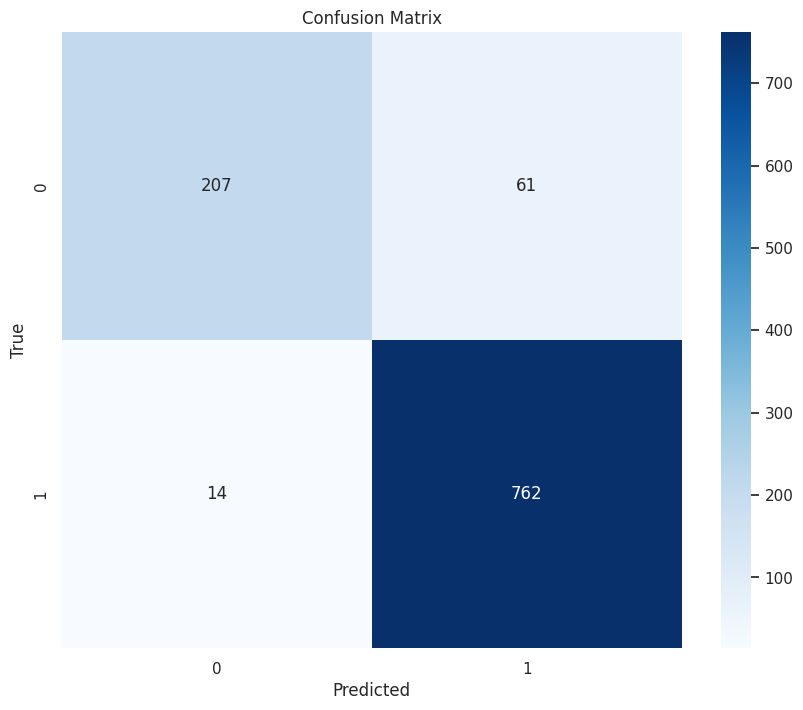

In [ ]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
results = model_encoder.evaluate(encoded_test,test_labels, verbose=True)

loss = round(results[0], 2)
accuracy = round(results[1] * 100, 2)

print(f'Test results - Loss: {loss} - Accuracy: {accuracy}%')

33/33 [==============================] - 0s 3ms/step - loss: 0.1818 - accuracy: 0.9282
Test results - Loss: 0.18 - Accuracy: 92.82%


###Prediction using Autoencoder based Model

In [ ]:
def predict_pneumonia_or_normal(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    encoded_img = encoder.predict(img)

    prediction = model_encoder.predict(encoded_img)

    if prediction[0] > 0.5:
        return '\nPrediction: Pneumonia (Class 1)\n'
    else:
        return '\nPrediction: Normal (Class 0)\n'

img_paths = [
    '/content/chest_xray/chest_xray/test/PNEUMONIA/person101_bacteria_484.jpeg',
    '/content/chest_xray/chest_xray/test/PNEUMONIA/person102_bacteria_487.jpeg',
    '/content/chest_xray/chest_xray/test/NORMAL/IM-0007-0001.jpeg',
    '/content/chest_xray/chest_xray/test/NORMAL/IM-0009-0001.jpeg'
]

for img_path in img_paths:
    prediction = predict_pneumonia_or_normal(img_path)
    print(f'For image {img_path}, {prediction}')

1/1 [==============================] - 0s 29ms/step
For image /content/chest_xray/chest_xray/test/PNEUMONIA/person101_bacteria_484.jpeg, 
Prediction: Pneumonia (Class 1)

1/1 [==============================] - 0s 31ms/step
For image /content/chest_xray/chest_xray/test/PNEUMONIA/person102_bacteria_487.jpeg, 
Prediction: Pneumonia (Class 1)

1/1 [==============================] - 0s 25ms/step
For image /content/chest_xray/chest_xray/test/NORMAL/IM-0007-0001.jpeg, 
Prediction: Normal (Class 0)

1/1 [==============================] - 0s 17ms/step
For image /content/chest_xray/chest_xray/test/NORMAL/IM-0009-0001.jpeg, 
Prediction: Normal (Class 0)

